## Fit of Neutron Reflectivity data from a polydisperse polymer Brush 

This example notebook is essentially an extension of the "Fit of Neutron Reflectivity data from a polymer Brush"-notebook where we consider the potential polydispersity of the grafted polymers by addition of a parameter for the standard deviation of the brush thickness.

Suppose that we want to fit NR data of a polymer brush at the Quartz/d-toluene interface. Polymer brushes have parabolic volume fraction profiles of the form: $\phi(z) = \phi(0) \left[ 1 - (\frac{z}{L})^n\right]$ where $\phi$ is the polymer volume fraction, $L$ is the brush extension, $n$ the exponent and $z$ the distance from the substrate.

If we want to consider the polydispesity of the grafted chains we may use the following expression for the solvent volume fraction within the brush layer $1-\phi(z)$

\begin{equation}
1- \phi(z)= \int_{L-4\sigma_{L}}^{L+4\sigma_{L}} \frac{1}{\sigma_{L} \sqrt{2\pi}} exp \left[ -\frac{1}{2} \left(\frac{x-L}{\sigma_{L}} \right)^2 \right] Min \left[1- \phi(0) \left( 1 - \left(\frac{z}{x} \right)^n \right), 1 \right] dx
\end{equation}

where we have assumed a Gaussian distribution of brush lengths with $\sigma_{L}$ beeing the standard deviation.

In the code below we will approximate the integral with a sum of the form

\begin{equation}
1- \phi(z)\approx \sum_{i=-40}^{i=40} \frac{1}{\sigma_{L} \sqrt{2\pi}} exp \left[ -\frac{1}{2} \left(\frac{i}{10} \right)^2 \right] Min \left[1- \phi(0) \left( 1 - \left(\frac{z}{L+i\sigma_{L}/10} \right)^n \right), 1 \right] (\sigma_{L}/10)
\end{equation}

Note that we use the _Min_ function in order to avoid $1-\phi(z)$ values larger than one.

First let's import _anaklasis.ref_

In [1]:
from anaklasis import ref

We name the project as 'Polydisperse_Brush_fit'. All results will be exported in a folder with this name. Then we import the experimental curve and we set input units to Angstrom.

In [2]:
project='Polydisperse_Brush_fit'
in_file=['DA34424a.dat']
units=['A'] # Angstrom units

then we set the details of the fit. Note that we will perform MCMC sampling.

In [3]:
fit_mode=0 # linear
fit_weight=[1] 
method = 'mcmc' # Markov Chain Monte Carlo

We define a single model where we add the Quartz semi-infinite fronting and a thin water layer that is always present on the substrate in these measurements. A global parameter (that will be defined later) is associated with the thickness of this thin water layer. All other layer parameters are fixed.

In [4]:
model=[
	# Re_sld Im_sld thk rough solv description
	[  4.32e-6, 0.0, 0, 5, 0.0, 'Quartz'],
	[ -0.56e-6, 0.0, 'p4', 3, 0.0, 'water'],
	]

We will now append 20 slices of $L/10$ thickness representing the polymer brush. These layers will all have the same polymer sld and a varying solvent volume fraction ($1-\phi(z)$). For this reason we first define a symbolic expression for the solvent volume fraction according to the expression we discussed above. Note that the summation index is _ii_ (in anaklasis, available summation indices are _ii,jj,kk_).

In [5]:
expr="""Sum(((1/(p2*(2*pi)**0.5))*exp(-0.5*(ii/10)**2))*
Min(1-p0+(p0/((p1+(ii/10)*p2)**p3))*((p1/10)*(n-1.5))**p3,1)
*(p2/10),(ii,-40,40))"""

where p0, p1, p2, p3 are global parameters (we will define them later) representing $\phi(0)$, $L$, $\sigma_{L}$ and the exponent. $n$ is the layer number that in the present case runs from 2 to 21. So the expression $(p1/10)*(n-1.5)$ gives the $z$ distance of each slice from the substrate. So now we append the slices of the brush in the model _list_ using a _for loop_.

In [6]:
for i in range(20): 
	model.append([ 1.41e-6, 0.0,'p1/10', 'p1/20', expr, 'layer'])

All slices have the same sld, same thickness and we also apply a roughness (half slice thickness) to smooth the profile. The volume fraction profile is set according to the above defined symbolic expression.

We also add at the end of the model the semi-infinite backing (d-toluene)

In [7]:
model.append([  5.86e-6, 0.0,  0, 0, 1.0, 'd-toluene'])

Now that the model _list_ is complete and since we have a single model (patch) of 100% coverage in our system, we define the _patches_ and _system_ _lists_. 

In [8]:
patches=[1.0]
system=[model]

Now we may define the global parameters. Note that the global parameters can be of type uniform or normal. For a uniform parameter we assume that the parameter is uniformly distributed in the given min/max bounds. For a normal parameter we assume that the parameter is normally distributed with the defined mean and standard deviation.

In [9]:
global_param = [
    # param  min  max  description  type='uniform'
    # param  mean  sd  description  type='normal'
	['p0', 0.02, 0.20, 'phi0','uniform'],
	['p1', 100, 700, 'brush_length','uniform'],
	['p2', 0, 100, 'brush_length_sd','uniform'],
	['p3', 1, 4, 'exponent','uniform'],
	['p4', 5, 1, 'water thickness','normal'],
	]

We have no multi-parameters to declare. We add only a constraint so that the brush length stays always bigger than four times the brush length standard deviation.

In [10]:
multi_param = [] # no multi-parameters
constraints = ['4*p2<p1'] 

we also define the instrumental parameters. Background and scale are set as fixed.

In [11]:
resolution=[0.07] # dQ/Q=7%
background = [[0.0,0.0,'uniform']] #background corrected data
scale = [[1.0,1.0,'uniform']] #data correctly scaled

We finally call the _ref.fit_ function and store the results in the _dictionary_ _res_. Note that we set _experror=True_ since our input data contain the $dR(Q)$ errors. 

--------------------------------------------------------------------
Program ANAKLASIS - Fit Module for X-ray/Neutron reflection datasets
version 1.5.0, August 2021
developed by Dr. Alexandros Koutsioumpas. JCNS @ MLZ
for bugs and requests contact: a.koutsioumpas[at]fz-juelich.de
--------------------------------------------------------------------
Project name: Polydisperse_Brush_fit
Using chi squared with errors figure of merit (FOM)
Fast fit mode. Using small differential evolution population size
Parameter uncertainity calculation using Markov Chain Monte Carlo
A plot summarizing results will pop-up after the end of the calculation


file#0 experimental points: 180
Q units in inverse A
dQ/Q =  0.07
fit weight:  1
free parameters =  5


list of free parameters: p0 (phi0),p1 (brush_length),p2 (brush_length_sd),p3 (exponent),p4 (water thickness),

Running differential evolution minimization...
/n
Success: True
Number of evaluation: 4273
Number of iterations: 31
FOM: 1.7853474100679372


100%|██████████| 500/500 [01:17<00:00,  6.47it/s]
N/50 = 10;
tau: [34.584 33.438 37.105 34.251 32.08 ]
  0%|          | 1/2220 [00:00<06:02,  6.12it/s]

MCMC production run..


100%|██████████| 2220/2220 [05:43<00:00,  6.46it/s]

Calculating mean curves...
  0%|          | 0/187 [00:00<?, ?it/s]

100%|██████████| 187/187 [00:22<00:00,  8.30it/s]
Plotting curves... please wait...


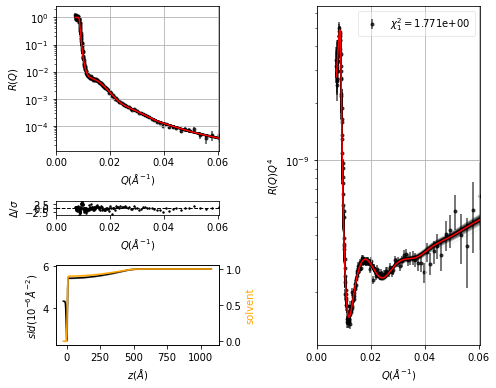

--------------------------------------------------------------------
Final model parameters
--------------------------------------------------------------------


Curve #0


Instrumental Resolution, dQ/Q: 0.07
fit weigth: 1
--------------------------------------------------------------------
Quartz real sld (10^-6 A^-2)      = 4.32 (fixed)
Quartz imaginary sld (10^-6 A^-2) = 0.00 (fixed)
Quartz thickness (A)              = 0.00 (fixed)
Quartz/water roughness (A) = 5.00 (fixed)
Quartz solvent volume fraction    = 0.00 (fixed)
--------------------------------------------------------------------
water real sld (10^-6 A^-2)      = -0.56 (fixed)
water imaginary sld (10^-6 A^-2) = 0.00 (fixed)
water thickness (A)              = 3.95 (parametric), -> p4
water/layer roughness (A) = 3.00 (fixed)
water solvent volume fraction    = 0.00 (fixed)
--------------------------------------------------------------------
layer real sld (10^-6 A^-2)      = 1.41 (fixed)
layer imaginary sld (10^-6 A^-2) = 0.

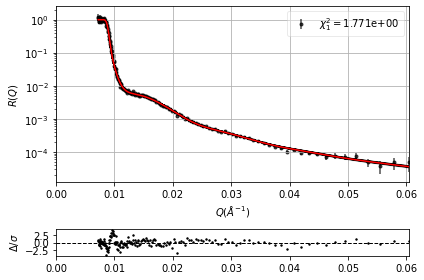

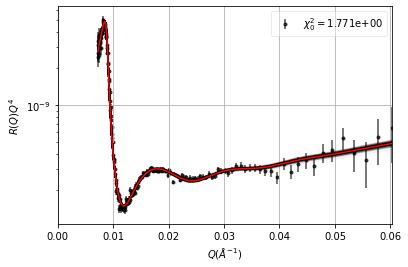

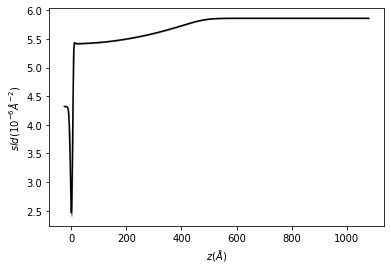

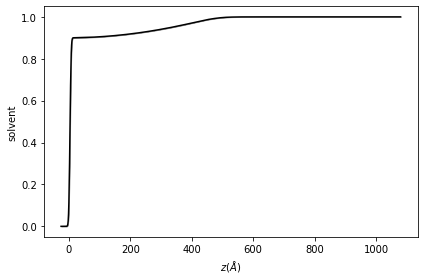

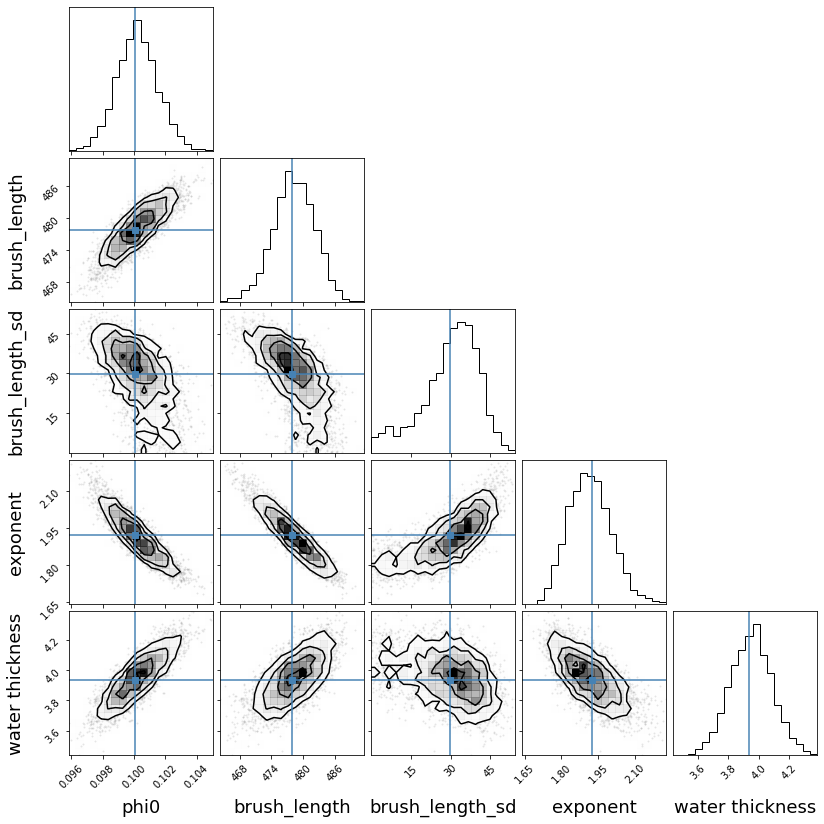

In [12]:
res = ref.fit(project, in_file, units, fit_mode,fit_weight,method,resolution,patches, system,
global_param,multi_param, constraints,background,scale,experror=True, plot=True,fast=True)

_anaklasis_ automatically exports a number of plots for the reflectivity and profiles. A corner plot from the MCMC sampling is exported. If we want to plot manually the volume fraction profile and "zoom" close to the region of the variation of the brush profile we may use the results stored in the res _dictionary_. 

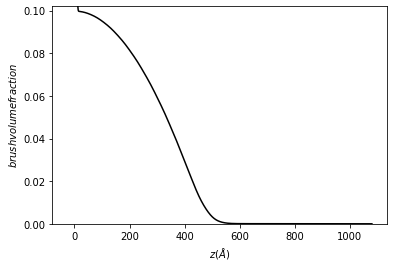

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.ylim([0.0,0.102])
plt.plot(res[("solvent")][:,0],1-res[("solvent")][:,1],color='black')
plt.xlabel(r'$z(\AA)$')
plt.ylabel(r'$brush volume fraction$')
plt.draw()